<a href="https://colab.research.google.com/github/ayj35/dd/blob/main/schedule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[[2.6516841e+09]
 [2.71613235e+09]
 [2.97002854e+09]
 ...
 [2.79178342e+09]
 [3.11905178e+09]
 [2.6160233e+09]]


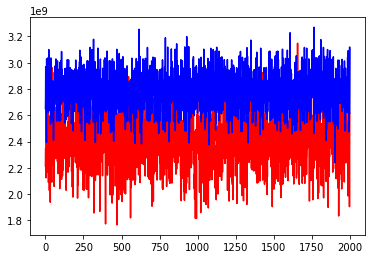

[[0.639165342],
 [0.710665643],
 [0.592790127],
 [0.225162059],
 [0.305471629],
 [0.633511901],
 [0.636444151],
 [0.403814554],
 [0.240465462],
 [0.446986675],
 [0.55869019],
 [0.30263707],
 [0.777264178],
 [0.625190675],
 [0.286071],
 [0.713495195],
 [0.396811634],
 [0.43396318],
 [0.235741258],
 [0.698210061],
 [0.484425366],
 [0.791783094],
 [0.302567959]]


InvalidArgumentError: ignored

In [195]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt


#2019/1/10 데이터 
#pv_data와 load_data는 예측한 데이터로 업데이트
#cost_rate 요금은 날짜에 따라 변경
#스케줄은 0시~22시까지 해당 시각이 지나고 bess에 남아있는 전력 비율을 표현. 23시는 0.5로 고정

pv_data = [0,0,0,0,0,0,0,0.6,11.8,58.5,125.2,196.1,235.7,308.1,68.8,48,25,1.5,0,0,0,0,0,0]
load_data = [2289.691328,2220.55251,2139.893597,2142.229235,2154.264593,2128.303845,2273.463212,2344.886263,2720.263838,2959.403796,3073.543529,3076.651304,
             3058.270636,3113.133338,3249.18376,3156.53531,3055.50211,3050.285312,2800.965106,2592.688452,2573.942551,2366.031,2381.41248,2352.104703]
cost_rate = [42.6,42.6,42.6,42.6,42.6,42.6,42.6,42.6,42.6,80.6,117.9,117.9,80.6,80.6,80.6,80.6,80.6,117.9,117.9,117.9,80.6,80.6,117.9,42.6]

max_charge=750

max_rate=0.8
min_rate=0.2


train_data = []

#요금 계산 함수

def cost(bess):
  schedule = bess
  reward = 0
  if(schedule[0]>=0.5):
    reward = reward+(load_data[0]-pv_data[0]*0.93*0.93+(schedule[0]-0.5)/0.93)*cost_rate[0]*max_charge
  else:
    reward = reward+(load_data[0]-pv_data[0]*0.93*0.93-(0.5-schedule[0])*0.93)*cost_rate[0]*max_charge
  if(schedule[0]>max_rate):
     reward+=(schedule[0]-0.8)*10000000
  if(schedule[0]<min_rate):
     reward+=(min_rate-schedule[0])*10000000
  for i in range(1,23):
    if(schedule[0]>max_rate):
      reward+=(schedule[0]-max_rate)*10000000
    if(schedule[0]<min_rate):
      reward+=(min_rate-schedule[0])*10000000
    if(schedule[i]>=schedule[i-1]):
      reward = reward+(load_data[i]-pv_data[i]*0.93*0.93+(schedule[i-1]-schedule[i])/0.93)*cost_rate[i]*max_charge
    else:
      reward = reward+(load_data[i]-pv_data[i]*0.93*0.93-(schedule[i-1]-schedule[i])*0.93)*cost_rate[0]*max_charge
  if(schedule[22]>=0.5):
    reward = reward+(load_data[23]-pv_data[23]*0.93*0.93+(schedule[22]-0.5)*0.93)*cost_rate[23]*max_charge
  else:
    reward = reward+(load_data[23]-pv_data[23]*0.93*0.93+(0.5-schedule[22])/0.93)*cost_rate[23]*max_charge
  reward = [reward]
  reward = tf.cast(reward,dtype=tf.float32)
  return reward

for e in range(2000):
    sch = tf.random.uniform(shape=[23],minval=min_rate*0.8,maxval=max_rate*1.1,dtype=tf.float32);
    rwd = cost(sch)
    sch = np.append(sch,rwd)
    if(e==0):
      train_data = sch
    else:
      train_data= np.vstack((train_data,sch))
    
train_data = np.random.permutation(train_data)


t_data = tf.cast(train_data[0:500],tf.float32)

x_data = train_data[:,0:23]

y_data = train_data[:,23:24]

X = tf.cast(x_data,tf.float32)
Y = tf.cast(y_data,tf.float32)
tf.print(Y)

W1 = tf.Variable(tf.random.uniform(shape=[23, 40], minval=0., maxval=100.,dtype=tf.float32),trainable=True)
W2 = tf.Variable(tf.random.uniform(shape=[40, 40], minval=0., maxval=100.,dtype=tf.float32),trainable=True)
W3 = tf.Variable(tf.random.uniform(shape=[40, 1], minval=0., maxval=100.,dtype=tf.float32),trainable=True)



b1 = tf.Variable(tf.zeros([40]),dtype=tf.float32,trainable=True)
b2 = tf.Variable(tf.zeros([40]),dtype=tf.float32,trainable=True)
b3 = tf.Variable(tf.zeros([1]),dtype=tf.float32,trainable=True)



trainable_variables=[W1,W2,W3,b1,b2,b3]
L1 = tf.math.add(tf.matmul(X, W1), b1)
L1 = tf.nn.relu(L1)
L2 = tf.math.add(tf.matmul(L1, W2), b2)
L2 = tf.nn.relu(L2)
model = tf.add(tf.matmul(L2, W3), b3)

#요금 계산 함수를 학습하여 인공신경망 모델 생성

def train():
  L1 = tf.math.add(tf.matmul(X, W1), b1)
  L1 = tf.nn.relu(L1)
  L2 = tf.math.add(tf.matmul(L1, W2), b2)
  L2 = tf.nn.relu(L2)
  model = tf.add(tf.matmul(L2, W3), b3)
  w = tf.subtract(Y,model)
  ww= tf.square(w)
  wow = tf.reduce_mean(ww)
  return wow;

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)




for step in range(1000):
    train_op = optimizer.minimize(train,trainable_variables)

prediction = model
target = Y

plt.plot(model, 'r')
plt.plot(Y,'b')
plt.show()

#임의의 스케줄을 모델에 넣고 요금이 최소가 나오도록 스케줄을 변경

X2=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(23):
  X2[i]=tf.Variable(tf.random.uniform(shape=[1], minval=0.2, maxval=0.8,dtype=tf.float32),trainable=True);
tf.print(X2)
trainable_variables2 = [X2]

def train2():
  L1 = tf.math.add(tf.matmul(X2, W1), b1)
  L1 = tf.nn.relu(L1)
  L2 = tf.math.add(tf.matmul(L1, W2), b2)
  L2 = tf.nn.relu(L2)
  model = tf.add(tf.matmul(L2, W3), b3)
  return cost(model);

for step in range(100):
    train_op = optimizer.minimize(train2,trainable_variables2)

tf.print(X2.numpy())

